# 9. Ordinary differential equations: Guaranteed enclosures

We end by discussing initial ideas about how interval methods can give guaranteed enclosures of solutions to initial-value problems for ordinary differential equations (ODEs).

Consider the ODE

$$ \dot{y} = f(y) = y^2$$

with initial condition $y(t=0) = y_0$,
where $y_0$ is an *interval*. We can think of this as un uncertain initial condition.

The solution of this equation is a function $t \mapsto y(t)$, where $y(t)$ is itself an interval. We want to find a guaranteed enclosure $Y(t)$ of $y(t)$ for *any* $t$ up to some final $h$.

First we set up the problem.

In [72]:
using IntervalArithmetic

In [73]:
f(y) = y^2

f (generic function with 1 method)

In [74]:
y0 = 1..1.01

[1, 1.01001]

## Guaranteed Euler step

The simplest standard numerical method for ODEs is the **Euler method**, which gives an approximation

$y(h) \simeq y_0 + h \, f(y_0)$.

This is an *uncontrolled* approximation, i.e. we are unable to find a rigorous bound that we can calculate for the error made. 

Using interval arithmetic we can find such a bound with a clever bootstrapping idea, as follows.

We need to impose a bound somewhere, since we know that if we don't the differential equation could explode to infinity.

Fix some interval $A$ containing $y_0$. We will try to flow for a time $h$ such that $y(t)$ *is guaranteed to remain inside the box $A$* for all $t \in [0, h]$. This excludes finite-time blow-up.

If $f$ is "sufficiently nice" (e.g. Lipschitz) then we know that there exists a solution for some small enough $h$.

For example, let's take

In [5]:
A = 0.5..10

y0 ⊆ A

true

Suppose we were able to rigorously bound $\dot{y}$ for all times $t \in [0,h]$ such that $m \le \dot{y}(t) \le M$. Then we would have bounds on the solution too:

$$y_0 + m \, h \le y(t) \le y_0 + M \, h$$

for all $t \in [0,h]$.

In terms of intervals, if $\dot{y} \in B := [m, M]$ then $y(t) \in y_0 + h \, B$, where $B$ is the *b*ound on the derivative.

Since $\dot{y}(t) = f(y(t))$, we can obtain such a bound using interval arithmetic: if $y(t)$ is guaranteed to remain inside $A$ for all $t \in [0, h]$, then $\dot{y}(t) \in f(A)$ for all $t \in [0, h]$ !


(Note that if we do not have a bound for $y(t)$, then we cannot bound $\dot{y}$.)

So take $B := f(A)$ and then fix $h$ such that $y_0 + h f(A) \subseteq A$:

In [6]:
h = interval(1.0)   # initial guess for h

y0 + h * f(A)

[1.25, 101.011]

In [7]:
y0 + h*f(A) ⊆ A

false

#### Exercise 

1. Find a value of $h$ for which this inequality holds.

We now have a guaranteed inclusion $Y(t)$ for $y(t)$, for all $t \in [0,h]$:

In [30]:
Y(t) = y0 + t*f(A)  

Y (generic function with 1 method)

In particular,

In [19]:
Y(h)

[1.01562, 7.26001]

(Note that $f(A)$ gives an estimate of the Lipschitz constant of the function $y$ over the set $A$.)

$Y(t)$ is a cone that increases as a function of $t$. Hence the set of values of $y$ covered in the evolution until time $t$ is contained in the hull $H_1 := y_0 \sqcup Y(h)$:

In [20]:
⊔ = hull
H = y0 ⊔ Y(h)

[1, 7.26001]

An alternative point of view is to think of this as $y_0 + [0,h] \times f(A)$, which gives the same result:

In [31]:
IntervalArithmetic.hull(a, b) = hull(interval(a), interval(b))

In [32]:
H1 = y0 + hull(0, h)*f(A)

[1, 7.26001]

So we have the inclusion
$y(t) \in H_1$ for all $t \in [0,h]$. This is *smaller* than $A$, so we can use it to get a better bound:

In [33]:
H2 = y0 + hull(0, h)*f(H1)

[1, 4.30423]

#### Exercise

1. Repeat this until you reach convergence. You can use the `dist` function to calculate the distance between two intervals.

Let's solve the ODE accurately and compare with this:

In [29]:
using DifferentialEquations

In [ ]:
g(u, p, t) = u^2

tspan = (0.0, h.hi)

Plot solutions from initial conditions in y0:

In [42]:
using Plots

In [65]:
function plot_solutions!(g, y0)

    for u0 in range(y0.lo, y0.hi, length=10)

        prob = ODEProblem(g, u0, tspan)
        sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

        plot!(sol)
    end
end

plot_solutions! (generic function with 1 method)

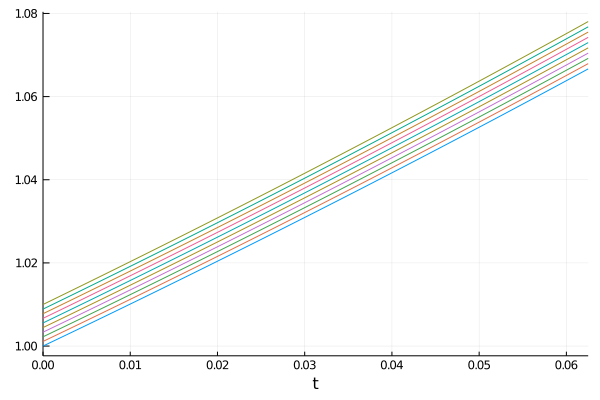

In [68]:
plot(leg=false)

plot_solutions!(g, y0)
plot!()

The box with vertical component $H$ must enclose all the trajectories:

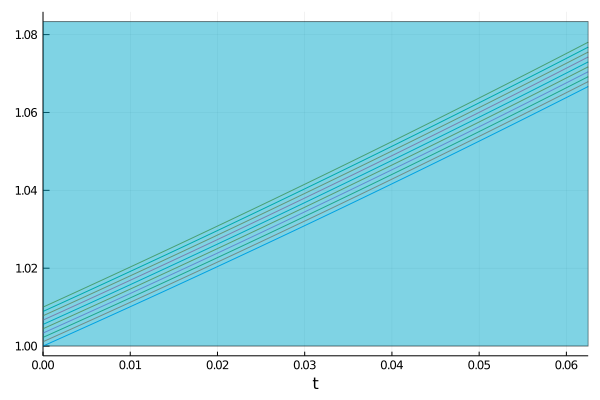

In [44]:
plot!(IntervalBox(hull(0, h), H))

We can also calculate the bounds for different $t$:

In [69]:
plot(leg=false)
plot_solutions!(g, y0)

In [70]:
Y(t) = y0 + t*f(H)  

Y (generic function with 1 method)

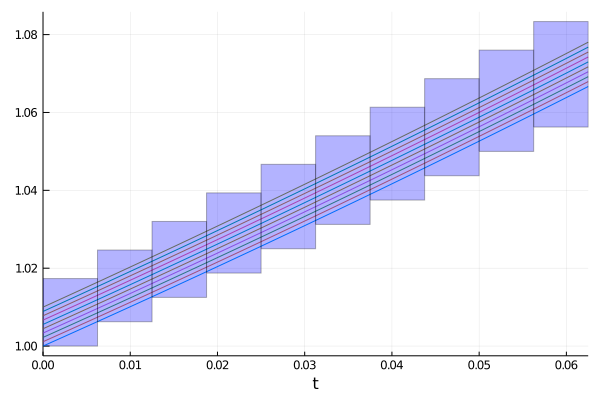

In [71]:
for t in mince(hull(0, h), 10)
    plot!(IntervalBox(t, Y(t)), c=:blue, alpha=0.3)
end

plot!()

(We could also just draw the cone.)

We can now continue with the next step starting from initial condition $Y(h)$.

Note that we are enclosing the function $y(t)$, as in notebook 2; the difference here is that we are constructing the enclosures of the previously unknown function as we go.

There is a major issue with this method: the intervals always expand over time. However the dynamics may contract instead and we would not be able to capture that.

## Taylor method

Here we have effectively carried out an interval Euler method. We can vastly improve the approximation by using higher-order Taylor expansions of the solution $y(t)$ in powers of $t$.